In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

# Preprocessing and metrics 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
# This is an edited version of the original dataframe (done in a previous notebook)
# Don't have to repeat the data cleaning steps again 

bicycle = pd.read_csv('Bike_Crash_edited')

## Preprocessing Step

In [3]:
# Label encode the 'CrashMonth' column instead of one-hot encoding it, since that would introduce too many additional columns

month_mapping = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }

bicycle['CrashMonth'] = bicycle['CrashMonth'].map(month_mapping)

In [4]:
# Label encode the 'CrashDay' column too

weekday_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

bicycle['CrashDay'] = bicycle['CrashDay'].map(weekday_mapping)

In [5]:
## The selected features (X)
features = ['CrashDay', 'CrashMonth', 'CrashHour', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

## Drop first columns of each one-hot encoded feature to avoid overfitting
X = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Target (y) is binary (no need to encode)
y = bicycle['AmbulanceR']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True)

# The Models

The models that we chose to work with are logistic regression, decision trees, and random forest, all of which work best for datasets that consist of all categorical variables (**Note:** one must still encode the features before fitting the models). 

We first focus on a target variable with only two categories, the 'AmbulanceR' column consisting of 'yes' or 'no'. This is a simple enough indicator on whether a bike accident was serious or not.

## Logistic Regression

In [6]:
## (Binary) Logistic Regression model

log_reg = LogisticRegression(penalty=None, max_iter=1000)

log_reg.fit(X_train, y_train)

## Evaluate on training and testing sets
train_log_pred = log_reg.predict(X_train)
test_log_pred = log_reg.predict(X_test)

In [7]:
print(f"Test accuracy:", accuracy_score(y_test, test_log_pred))
print(f"Training accuracy:", accuracy_score(y_train, train_log_pred))

Test accuracy: 0.6793229643183898
Training accuracy: 0.6931701178354879


In [29]:
# Perform cross-validation (to check for overfitting)
cv_scores = cross_val_score(log_reg, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.69030192 0.69030192 0.69061785 0.69061785 0.69016018]
Mean cross-validation score: 0.690399944728363


### (Binary) Classification Evaluation Metrics

$$
\text{accuracy} = \frac{\text{TP+TN}}{\text{TP} + \text{TP+TN+FP+FN}},
$$

$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}},
$$

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}.
$$


The **$F_1$-score** is defined to be

$$F_1 = \frac{2}{\text{precision}^{-1} + \text{recall}^{-1}}$$

which is the harmonic mean of precision and recall. It is used as a performance metric for classification, and great for unbalanced data, hence is better than accuracy in these scenarios. 

- Excellent: $\quad F_1>0.9$ 
- Good: $\quad 0.8 \le F_1\le 0.9$ 
- Average: $\quad 0.5 \le F_1\le 0.8$ 
- Poor: $\quad F_1<0.5$ 

In [38]:
# zero_division=0.0 was set to advoid warning
# means that some classes in y_test were not predicted (why?)

print(classification_report(y_test, test_log_pred, zero_division=0.0,
                            target_names = ['Ambulance: no', 'Ambulance: yes']))

                precision    recall  f1-score   support

 Ambulance: no       0.00      0.00      0.00       701
Ambulance: yes       0.68      1.00      0.81      1485

      accuracy                           0.68      2186
     macro avg       0.34      0.50      0.40      2186
  weighted avg       0.46      0.68      0.55      2186



Odds ratio: 
- $e^\beta < 1$ indicates a decrease in the odds of the outcome
- $e^\beta > 1$ indicates an incease in the odds of the outcome

In [39]:
# Odds ratio
np.exp(log_reg.coef_)

array([[1.02457956, 1.02453052, 1.00512592, 0.97382557, 0.82799491,
        1.31529637, 0.90969273, 0.6878811 , 0.87946525, 0.90462126,
        0.88819927]])

In [40]:
print(f"The mean of predicted probablities when an ambulance was called is", log_reg.predict_proba(X_train)[:,1].mean())

The mean of predicted probablities when an ambulance was called is 0.6931822326503855


In [ ]:
# Same as random forest
confusion_matrix(y_test, test_log_pred)

array([[   0,  701],
       [   0, 1485]])

## Decision Trees

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=4, random_state= 216)

tree_clf.fit(X_train, y_train)

pred_tree_clf = tree_clf.predict(X_test)

In [13]:
accuracy_score(y_test, pred_tree_clf)

0.6765782250686185

In [ ]:
# The mean cv score for random forest is slightly smaller than the one for logistic regression (0.69)

cv_scores = cross_val_score(tree_clf, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.68755718 0.68984446 0.68832952 0.69061785 0.68970252]
Mean cross-validation score: 0.6892103064854147


In [37]:
# Did not get any warnings here, unlike for the logistic regression model (why?)
# Get the same exact table 

print(classification_report(y_test, pred_tree_clf, target_names = ['Ambulance: no', 'Ambulance: yes']))

                precision    recall  f1-score   support

 Ambulance: no       0.00      0.00      0.00       701
Ambulance: yes       0.68      1.00      0.81      1485

      accuracy                           0.68      2186
     macro avg       0.34      0.50      0.40      2186
  weighted avg       0.46      0.68      0.55      2186



In [14]:
pd.DataFrame({'features' : X_train.columns,
              'importance_score' : tree_clf.feature_importances_}).sort_values('importance_score', ascending=False)

,features,importance_score
2,CrashHour,0.426757
0,CrashDay,0.220661
1,CrashMonth,0.140621
7,Region_Mountains,0.073100
9,TraffCntrl_No Control Present,0.050950
3,NumLanes_No 2 lanes,0.046706
10,Weather_Not Clear,0.041204
4,RdCharacte_Straight - Level,0.000000
5,RdConditio_Not Dry,0.000000
6,RdFeature_Special Feature,0.000000


## Random Forest

In [15]:
forest = RandomForestClassifier(n_estimators=500, max_depth=4)

forest.fit(X_train, y_train)

forest_test_pred = forest.predict(X_test)
forest_train_pred = forest.predict(X_train)

In [16]:
print(f"Test accuracy:", accuracy_score(y_test, forest_test_pred))
print(f"Train accuracy:", accuracy_score(y_train, forest_train_pred))

# print(f"Percision:", precision_score(y_test, forest_pred, average=None))
# print(f"Recall:", recall_score(y_test, forest_pred, pos_label=str))

Test accuracy: 0.6793229643183898
Train accuracy: 0.6931701178354879


In [ ]:
# mean cv score is same as logistic regression

cv_scores = cross_val_score(forest, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.69030192 0.69030192 0.69061785 0.69061785 0.69016018]
Mean cross-validation score: 0.690399944728363


In [43]:
print(classification_report(y_test, forest_test_pred, zero_division=0.0,
                            target_names = ['Ambulance: no', 'Ambulance: yes']))

                precision    recall  f1-score   support

 Ambulance: no       0.00      0.00      0.00       701
Ambulance: yes       0.68      1.00      0.81      1485

      accuracy                           0.68      2186
     macro avg       0.34      0.50      0.40      2186
  weighted avg       0.46      0.68      0.55      2186



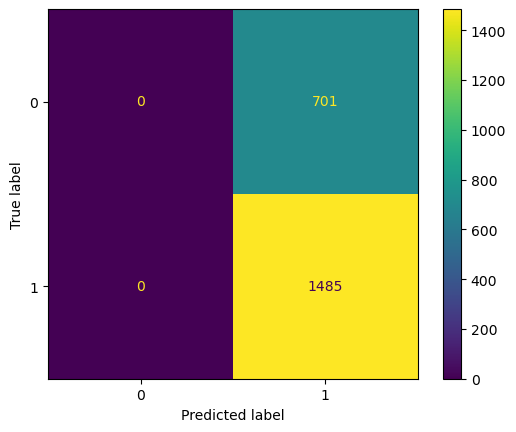

In [17]:
ConfusionMatrixDisplay(confusion_matrix(y_test, forest_test_pred)).plot()

In [18]:
pd.DataFrame({'feature' : X_train.columns,
              'importance_score' : forest.feature_importances_}).sort_values('importance_score', ascending=False)

,feature,importance_score
2,CrashHour,0.306680
1,CrashMonth,0.187436
0,CrashDay,0.122441
7,Region_Mountains,0.079364
4,RdCharacte_Straight - Level,0.065070
6,RdFeature_Special Feature,0.057122
9,TraffCntrl_No Control Present,0.045222
5,RdConditio_Not Dry,0.040117
8,Region_Piedmont,0.037018
3,NumLanes_No 2 lanes,0.035749


### Hyperparameter Tuning


The code below randomly searches for the best hyperparameters, in a given range for each hyperparameter, for the random forest model.

In [19]:
# The chosen hyperparameters for the random forest model, and their given ranges, stored in a dictionary 
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

# This takes a while to run
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 307}


# Multi Classification

We train our models with a multi categorical target the 'BikeInjury' column.

In [20]:
## The selected features (X)
features = ['CrashDay', 'CrashMonth', 'CrashHour', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

## The same features 
X_multi = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Multi-categorical target (no need to encode)
y_multi = bicycle['BikeInjury']

## Split data into training and testing sets
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y_multi, 
                                                    test_size=0.2, 
                                                    random_state=512,
                                                    shuffle=True)

## Multinomial Logistic Regression

In [21]:
## Multinomial Logistic Regression model

multilog_reg = LogisticRegression(penalty=None, max_iter=1000)

multilog_reg.fit(X_multi_train, y_multi_train)

## Evaluate on training and testing sets
train_multilog_pred = multilog_reg.predict(X_multi_train)
test_multilog_pred = multilog_reg.predict(X_multi_test)

In [22]:
print(f"Test accuracy:", accuracy_score(y_multi_test, test_multilog_pred))
print(f"Training accuracy:", accuracy_score(y_multi_train, train_multilog_pred))

Test accuracy: 0.4464775846294602
Training accuracy: 0.44846127445372386


In [23]:
cv_scores = cross_val_score(multilog_reg, X_multi, y_multi, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.44098811 0.43549863 0.42974828 0.44576659 0.44073227]
Mean cross-validation score: 0.4385467746696786


It appears that the multinomial logistic regression model performs less accurate than the binomial logistic regression model.

In [24]:
i = 0
for cat in multilog_reg.classes_:
    print(f"Mean of predicted probabilities of class '{cat}':", multilog_reg.predict_proba(X_multi_train)[:,i].mean())
    i =+ 1

Mean of predicted probabilities of class 'A: Suspected Serious Injury': 0.05319172307149092
Mean of predicted probabilities of class 'B: Suspected Minor Injury': 0.42876261639229724
Mean of predicted probabilities of class 'C: Possible Injury': 0.42876261639229724
Mean of predicted probabilities of class 'K: Killed': 0.42876261639229724
Mean of predicted probabilities of class 'O: No Injury': 0.42876261639229724


In [ ]:
# Evaluation metrics for multi classification
print(classification_report(y_multi_test, test_multilog_pred, zero_division=0.0))

                             precision    recall  f1-score   support

A: Suspected Serious Injury       0.00      0.00      0.00       112
  B: Suspected Minor Injury       0.44      0.65      0.52       912
         C: Possible Injury       0.46      0.43      0.44       895
                  K: Killed       0.00      0.00      0.00        48
               O: No Injury       0.00      0.00      0.00       219

                   accuracy                           0.45      2186
                  macro avg       0.18      0.22      0.19      2186
               weighted avg       0.37      0.45      0.40      2186



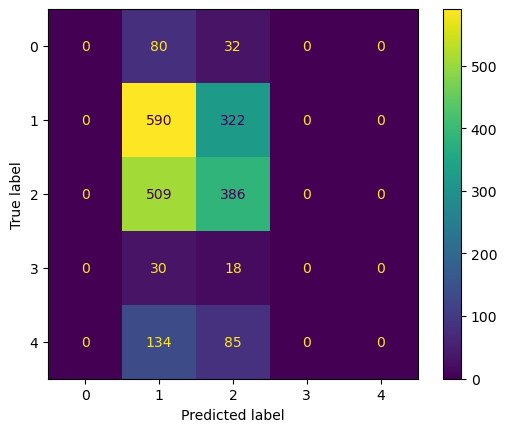

In [25]:
cm = confusion_matrix(y_multi_test, test_multilog_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Random Forest (multiple targets)

In [26]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=4)

rfc.fit(X_multi_train, y_multi_train)

rfc_test_pred = forest.predict(X_multi_test)
rfc_train_pred = forest.predict(X_multi_train)

In [ ]:
# This has a zero accuracy score 
# Is random forest bad for multi-output?

print(f"Test accuracy:", accuracy_score(y_multi_test, rfc_test_pred))
print(f"Train accuracy:", accuracy_score(y_multi_train, rfc_train_pred))

Test accuracy: 0.0
Train accuracy: 0.0
